# Inferência e validação

Agora que treinamos a rede, podemos usá-la para fazer predições. Esse processo é chamado de **inferência**, um termo emprestado da estatística. No entanto, redes neurais tem uma tendencia de aprender *muito bem* o comportamento dos dados de treinamento, e as vezes apresentam dificuldade para generalizar esse conhecimento para dados desconhecidos, i.e., conjunto de testes. Esse problema é chamado de **overfitting**, o qual prejudica a performance da inferência. Para testar se está ocorrendo overfitting enquanto treinamos o modelo, podemos avaliar a sua performance em um conjunto especial de dados chamado conjunto de **validação**. Podemos evitar o _overfitting_ usando técnicas de regularização, como por exemplo **dropout**, enquanto monitoramos a performance da validação durante o treinamento.

Como de costume, vamos começar carregando o conjunto de dados utilizando torchvision. Podemos baixar o conjunto de testes setando `train=False`:

```python
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
```

O conjunto de teste geralmente contém 20% a 30% do tamanho total do dataset, e é usado para validar e testar o modelo.

In [1]:
import torch
from torchvision import datasets, transforms

# Define as transformações para normalizar os dados
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Baixa e carrega o conjunto de treinamento
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# baixa e carrega o conjunto de testes
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

Extracting /home/roder/.pytorch/F_MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /home/roder/.pytorch/F_MNIST_data/FashionMNIST/raw


Extracting /home/roder/.pytorch/F_MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /home/roder/.pytorch/F_MNIST_data/FashionMNIST/raw


Extracting /home/roder/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /home/roder/.pytorch/F_MNIST_data/FashionMNIST/raw



Extracting /home/roder/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /home/roder/.pytorch/F_MNIST_data/FashionMNIST/raw
Processing...


/home/roder/anaconda3/envs/deep/lib/python3.7/site-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


Vamos criar um model MLP com 3 camadas escondidas, uma com 256, uma com 128 e uma com 64 neurônios.

In [2]:
from torch import nn, optim
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
    def forward(self, x):
        # certificar que o tensor com as imagens foi 'achatado'
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

O objetivo do conjunto de validação é medir a performance do modelo durante o treinamento sem usar as amostras empregadas para ajustar os pesos. Essa performance pode ser medida pela acurácia, taxa de acerto, entre outras opções. No exemplo usaremos a acurácia. Vamos começar fazendo o passo _forward_ sobre o conjunto de testes.

In [3]:
model = Classifier()

images, labels = next(iter(testloader))
# Computa a probabilidade das classes (lembrando que usa exp por que a saída da rede é log_softmax)
ps = torch.exp(model(images))
# confirmando se o formato da saída é apropriada, i.e., 64 amostras com probabilidade de pertencer a 10 classes
print(ps.shape)

torch.Size([64, 10])


Com esse vetor de probabilidades, podemos pegar a classe mais provável usando o método `ps.topk`, o qual retorna os $k$ maiores valores. Como queremos saber qual é a (única) classe mais provavel, usamos `ps.topk(1)`. A função retorna uma tupla com os $k$ maiores valores e seus indices. 

In [4]:
top_p, top_class = ps.topk(1, dim=1)
# Veja as classes mais prováveis para as 10 primeiras amostras
print(top_class[:10,:])

tensor([[8],
        [8],
        [8],
        [8],
        [8],
        [8],
        [8],
        [8],
        [8],
        [8]])


Para verificar se a classe estimada corresponde ao rótulo, comparamos `top_class` e `labels`. Lembre que `top_class` é um tensor 2D com formato `(64, 1)`, enquanto `labels` é 1D com formato `(64)`, e para igualá-los, precisamos ajustar o formato do nosso tensor labels:

In [5]:
equals = top_class == labels.view(*top_class.shape)
# * quer dizer que está desempacotando os valores da lista top_class.shape, ou seja, é o mesmo que 
#   fazer labels.view(top_class.shape[0],top_class.shape[1])

print('top_class.shape = ', top_class.shape)
print('*top_class.shape = ', *top_class.shape)
print('equals.shape = ', equals.shape)
#print('equals = ', equals)

top_class.shape =  torch.Size([64, 1])
*top_class.shape =  64 1
equals.shape =  torch.Size([64, 1])


Agora precisamos calcular a porcentagem de predições corretas. `equals` é composto por uma lista de valores binarios, o que significa que se somarmos os acertos e dividir pelo tamanho do vetor teremos a porcentagem de estimativas corretas, ou seja, é o mesmo que computar a média, o que poderia ser feito usando `torch.mean`. No entanto, usando `torch.mean(equals)` teremos o erro:

```
RuntimeError: mean is not implemented for type torch.ByteTensor 
```
ou
```
RuntimeError: Can only calculate the mean of floating types. Got Bool instead.
```

Isso porque `equals` é do tipo `torch.ByteTensor` ou `torch.bool`, mas `torch.mean` não funciona pra esses tipos de dados. Então devemos converter `equals` para tensor de floats. Note que `torch.mean` retorna um tensor com um escalar, e para pegar o valor de fato desse tensor devemos usar `accuracy.item()`.

In [6]:
accuracy = torch.mean(equals.type(torch.FloatTensor))
print(f'Acurácia: {accuracy.item()*100}%')

Acurácia: 7.8125%


A rede não foi treinada, por isso apresentou resultados ruins. Agora vamos treinar a rede e incluir um passo de validação para avaliar o quanto a rede progride sobre dados desconhecidos. Visto que não vamos computar os gradientes nessa etapa, devemos desligar o autograd para deixar o processo mais rápido usando `torch.no_grad()`:

```python
# desligando o calculo dos gradientes
with torch.no_grad():
    # passo de validação
    for images, labels in testloader:
        ...
```

In [7]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 30
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        # else pode ser usado em laços tipo for no python, e só será executado se não cair em nenhum break
        test_loss = 0
        accuracy = 0
        with torch.no_grad():
            # passo de validação
            for images, labels in testloader:
                log_ps = model(images)
                ps = torch.exp(log_ps)
                
                test_loss += criterion(log_ps, labels)  
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy+= torch.mean(equals.type(torch.FloatTensor))
                
        train_losses.append(running_loss / len(trainloader))
        test_losses.append(test_loss / len(testloader))
                
        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_losses[-1]),
              "Test Loss: {:.3f}.. ".format(test_losses[-1]),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))




Epoch: 1/30..  Training Loss: 0.514..  Test Loss: 0.460..  Test Accuracy: 0.833
Epoch: 2/30..  Training Loss: 0.397..  Test Loss: 0.433..  Test Accuracy: 0.848
Epoch: 3/30..  Training Loss: 0.358..  Test Loss: 0.441..  Test Accuracy: 0.843
Epoch: 4/30..  Training Loss: 0.338..  Test Loss: 0.375..  Test Accuracy: 0.868
Epoch: 5/30..  Training Loss: 0.316..  Test Loss: 0.374..  Test Accuracy: 0.866
Epoch: 6/30..  Training Loss: 0.303..  Test Loss: 0.368..  Test Accuracy: 0.872
Epoch: 7/30..  Training Loss: 0.296..  Test Loss: 0.379..  Test Accuracy: 0.873
Epoch: 8/30..  Training Loss: 0.282..  Test Loss: 0.368..  Test Accuracy: 0.872
Epoch: 9/30..  Training Loss: 0.272..  Test Loss: 0.377..  Test Accuracy: 0.871
Epoch: 10/30..  Training Loss: 0.267..  Test Loss: 0.382..  Test Accuracy: 0.874
Epoch: 11/30..  Training Loss: 0.259..  Test Loss: 0.378..  Test Accuracy: 0.878
Epoch: 12/30..  Training Loss: 0.254..  Test Loss: 0.378..  Test Accuracy: 0.877
Epoch: 13/30..  Training Loss: 0.2

## Overfitting

Se olharmos para os valores de loss sobre o conjunto de treinamento e de teste veremos um fenômeno conhecido como overfitting:

<img src='assets/overfitting.png' width=450px>

A rede aprende o comportamento do conjunto de treinamento cada vez melhor, reduzindo o erro nesse contexto. No entanto, tem problemas para generalizar e classificar corretamente os dados desconhecidos. O objetivo maior dos algoritmos de aprendizado de máquina é poder predizer e fazer estimativas sobre dados desconhecidos, por isso o objetivo deve ser minimizar o erro sobre o conjunto de validação/testes. Uma possível solução, chamada *parada-antecipada* (_early-stop_) seria salvar o modelo a cada época e usar a rede com melhor resultado sobre o conjunto de validação, no entanto não é a melhor opção.

A abordagem mais comum para reduzir overfitting é a utilização de técnicas de regularização. Veremos a seguir como usar uma técnica chamada *dropout* para essa tarefa, a qual seleciona de forma aleatória, a cada iteração, alguns neurônios para serem desligados. Dropout força a rede a compartilhar informações pelos pesos, reforçando seu poder de generalização. Adicionar dropout ou PyTorch é bem simples, basta utilizar o módulo [`nn.Dropout`](https://pytorch.org/docs/stable/nn.html#torch.nn.Dropout).


<img src='assets/dropout.png' width=550px>

```python
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
        # Módulo Dropout com probabilidade de 0.2 para desligar um neurônio
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        # aplicando 'flattening' nas imagens
        x = x.view(x.shape[0], -1)
        
        # Agora com dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        
        # saída - não há dropout aqui
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x
```

Durante o treinamento nos queremos usar dropout para evitar overfitting, mas durante a inferência, queremos usar a rede completa. Sendo assim, precisamos desligar o dropout durante o processo de validação, teste, ou qualquer etapa em que usemos a rede para fazer predições. Para isso, usaremos `model.eval()`, que seta o modelo para o modo de avaliação e desliga o dropout. O dropout pode ser religado voltando ao modo de treino com `model.train()`. No geral, o padrão para o laço de validação tem o formato a seguir, onde a desligamos a computação do gradiente e setamos o modelo para modo de avaliação, calculamos o loss e as métricas, e depois setamos de volta para o modo de treinamento.

```python
# desligar a computação dos gradientes
with torch.no_grad():
    
    # setar para modo de avaliação
    model.eval()
    
    # passagem das amostras de validação/teste
    for images, labels in testloader:
        ...

# volta o modelo para modo treinamento
model.train()
```

In [8]:
from torch import nn, optim
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(784,256)
        self.fc2 = nn.Linear(256,128)
        self.fc3 = nn.Linear(128,64)
        self.fc4 = nn.Linear(64,10)
        
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self,x):
        x = x.view(x.shape[0],-1)
        
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        
        x = F.log_softmax(self.fc4(x))
        
        return x


In [9]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 30
train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for image, label in trainloader:
        optimizer.zero_grad()
        log_ps = model(image)
        loss = criterion(log_ps, label)
        loss.backward()
        optimizer.step()
        
        running_loss+=loss.item()
    else:
        test_loss = 0
        accuracy = 0
        with torch.no_grad():
            model.eval()
            for image, label in testloader:         
                
                log_ps = model.forward(image)
                prob = torch.exp(log_ps)
                
                test_loss+= criterion(log_ps, label)
                
                
                k_prob, k_class = prob.topk(1, dim=1)
                equals = k_class == label.view(*k_class.shape)
                
                accuracy+= torch.mean(equals.type(torch.FloatTensor))
        
        model.train()
    train_losses.append(running_loss/len(trainloader))
    test_losses.append(test_loss/len(testloader))
    print("Epoch: {}/{}.. ".format(e+1, epochs),
          "Training Loss: {:.3f}.. ".format(train_losses[-1]),
          "Test Loss: {:.3f}.. ".format(test_losses[-1]),
          "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

/home/roder/anaconda3/envs/deep/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 1/30..  Training Loss: 0.603..  Test Loss: 0.460..  Test Accuracy: 0.834
Epoch: 2/30..  Training Loss: 0.487..  Test Loss: 0.486..  Test Accuracy: 0.835
Epoch: 3/30..  Training Loss: 0.451..  Test Loss: 0.440..  Test Accuracy: 0.838
Epoch: 4/30..  Training Loss: 0.433..  Test Loss: 0.404..  Test Accuracy: 0.855
Epoch: 5/30..  Training Loss: 0.418..  Test Loss: 0.392..  Test Accuracy: 0.861
Epoch: 6/30..  Training Loss: 0.415..  Test Loss: 0.423..  Test Accuracy: 0.846
Epoch: 7/30..  Training Loss: 0.406..  Test Loss: 0.401..  Test Accuracy: 0.854
Epoch: 8/30..  Training Loss: 0.397..  Test Loss: 0.419..  Test Accuracy: 0.852
Epoch: 9/30..  Training Loss: 0.396..  Test Loss: 0.383..  Test Accuracy: 0.861
Epoch: 10/30..  Training Loss: 0.385..  Test Loss: 0.390..  Test Accuracy: 0.860
Epoch: 11/30..  Training Loss: 0.380..  Test Loss: 0.392..  Test Accuracy: 0.859
Epoch: 12/30..  Training Loss: 0.387..  Test Loss: 0.377..  Test Accuracy: 0.869
Epoch: 13/30..  Training Loss: 0.381.

## Inferência

Agora que treinamos o modelo, podemos usá-lo para inferência. Já fizemos isso antes, mas agora precisamos lembrar de setar o modelo para o mode de inferência com `model.eval()`. Precisamos também desligar o autograd usando `torch.no_grad()`.


/home/roder/anaconda3/envs/deep/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


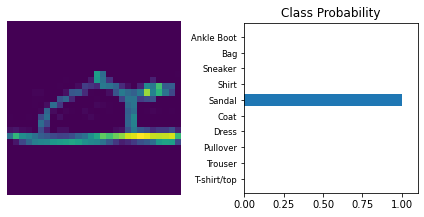

In [10]:
# Importando o módulo helper para ajudar a plotar
import helper

# Testando nossa rede

model.eval()

dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[0]
# Convertendo imagens 2D em tensores 1D
img = img.view(1, 784)

# Computando o log das probabilidades para cada imagem (com log_softmax)
with torch.no_grad():
    output = model.forward(img)

# computa as probabilidades fazendo o exponencial do log das probabilidades 
ps = torch.exp(output)

# plotando as probabilidades
helper.view_classify(img.view(1, 28, 28), ps, version='Fashion')

# Salvando e carregando modelos

Agora aprenderemos a salvar e a carregar os modelos treinados. É muito importante pois, frequentemente, precisaremos salvar os modelos após treiná-los para usá-lo em predições sobre novos dados.

In [11]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms

import helper
import fc_model

In [12]:
# Define a transformação para normalizar os dados
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# download e carrega os dados de treinamento
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# download e carrega os dados de validação/teste
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

Visualizando uma das imagens

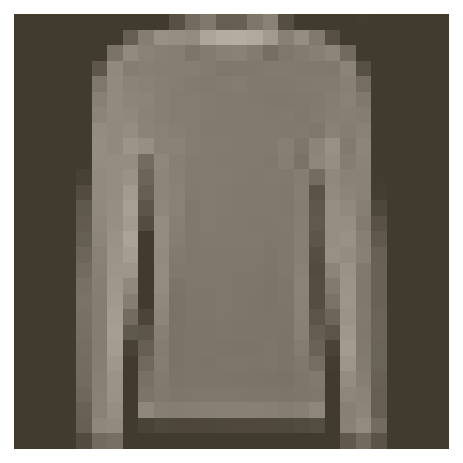

In [13]:
image, label = next(iter(trainloader))
helper.imshow(image[0,:]);

# Treinando a rede

Para não ficar muito confuso com muito código, a parte de modelagem da rede que já apredemos foi escrita no arquivo `fc_model`. Com esse arquivo, podemos criar uma rede chamando `fc_model.Network` e treiná-la com o comando `fc_model.train`. Após treiná-lo, será usado como exemplo para demonstrar como salvar e carregar modelos.

In [14]:
# Criando a rede, definindo o criterion (função loss) e o otimizador
model = fc_model.Network(784, 10, [512, 256, 128])
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [15]:
fc_model.train(model, trainloader, testloader, criterion, optimizer, epochs=2) # print every 40 iterations

Epoch: 1/2..  Training Loss: 1.731..  Test Loss: 0.984..  Test Accuracy: 0.637
Epoch: 1/2..  Training Loss: 1.040..  Test Loss: 0.769..  Test Accuracy: 0.732
Epoch: 1/2..  Training Loss: 0.871..  Test Loss: 0.685..  Test Accuracy: 0.738
Epoch: 1/2..  Training Loss: 0.803..  Test Loss: 0.678..  Test Accuracy: 0.726
Epoch: 1/2..  Training Loss: 0.761..  Test Loss: 0.619..  Test Accuracy: 0.761
Epoch: 1/2..  Training Loss: 0.728..  Test Loss: 0.612..  Test Accuracy: 0.771
Epoch: 1/2..  Training Loss: 0.724..  Test Loss: 0.561..  Test Accuracy: 0.790
Epoch: 1/2..  Training Loss: 0.688..  Test Loss: 0.570..  Test Accuracy: 0.792
Epoch: 1/2..  Training Loss: 0.649..  Test Loss: 0.600..  Test Accuracy: 0.776
Epoch: 1/2..  Training Loss: 0.664..  Test Loss: 0.561..  Test Accuracy: 0.782
Epoch: 1/2..  Training Loss: 0.608..  Test Loss: 0.538..  Test Accuracy: 0.800
Epoch: 1/2..  Training Loss: 0.601..  Test Loss: 0.537..  Test Accuracy: 0.797
Epoch: 1/2..  Training Loss: 0.638..  Test Loss: 0.5

## Salvando e carregando o modelo

Como já devem ter percebido, não é prático ficar treinando a rede toda hora que precisar usá-la. Em vez disso, podemos salvar o modelo treinado e carregá-lo para usar mais tarde para continuar o treinamento ou fazer predições.

Os parâmetros da rede são armazenados em um `state_dict`. Esse 'dicionário de estados' contém os pesos e biases para cada uma das camadas.

In [16]:
print("Nosso modelo: \n\n", model, '\n')
print("As chaves do dicionário: \n\n", model.state_dict().keys())

Nosso modelo: 

 Network(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=128, bias=True)
  )
  (output): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
) 

As chaves do dicionário: 

 odict_keys(['hidden_layers.0.weight', 'hidden_layers.0.bias', 'hidden_layers.1.weight', 'hidden_layers.1.bias', 'hidden_layers.2.weight', 'hidden_layers.2.bias', 'output.weight', 'output.bias'])


O modo mais simples de salvar o modelo é usando `torch.save`. Podemos, por exemplo, salvá-lo num arquivo `'checkpoint.pth'`.

In [17]:
torch.save(model.state_dict(), 'checkpoint.pth')

E depois carregá-lo usando `torch.load`.

In [18]:
state_dict = torch.load('checkpoint.pth')
print(state_dict.keys())

odict_keys(['hidden_layers.0.weight', 'hidden_layers.0.bias', 'hidden_layers.1.weight', 'hidden_layers.1.bias', 'hidden_layers.2.weight', 'hidden_layers.2.bias', 'output.weight', 'output.bias'])


Na sequência, carregamos nosso state_dict na rede, usando o comando `model.load_state_dict(state_dict)`.

In [19]:
model.load_state_dict(state_dict)

<All keys matched successfully>

Parece bem simples, mas como já estamos acostumados, nunca é tão fácil. Carregar o dicionário de estados só funciona se a arquitetura for exatamente a mesma que a do modelo salvo no checkpoint. Se criar um novo modelo com alguma diferença na arquitetura o método falha.

In [20]:
# Testando uma nova rede
model = fc_model.Network(784, 10, [400, 200, 100])
# Vai dar erro porque o número de neurônios nas camadas escondidas são diferentes
model.load_state_dict(state_dict)

RuntimeError: Error(s) in loading state_dict for Network:
	size mismatch for hidden_layers.0.weight: copying a param with shape torch.Size([512, 784]) from checkpoint, the shape in current model is torch.Size([400, 784]).
	size mismatch for hidden_layers.0.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([400]).
	size mismatch for hidden_layers.1.weight: copying a param with shape torch.Size([256, 512]) from checkpoint, the shape in current model is torch.Size([200, 400]).
	size mismatch for hidden_layers.1.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([200]).
	size mismatch for hidden_layers.2.weight: copying a param with shape torch.Size([128, 256]) from checkpoint, the shape in current model is torch.Size([100, 200]).
	size mismatch for hidden_layers.2.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([100]).
	size mismatch for output.weight: copying a param with shape torch.Size([10, 128]) from checkpoint, the shape in current model is torch.Size([10, 100]).

Isso significa que precisaremos reconstruir exatamente o mesmo modelo usado no treinamento, salvando também as informações sobre a arquitetura do modelo no checkpoint, junto com o state dict. Para isso, construiremos um dicionário com todas as informações necessárias reconstruir o modelo completamente.

In [21]:
checkpoint = {'input_size': 784,
              'output_size': 10,
              'hidden_layers': [each.out_features for each in model.hidden_layers],
              'state_dict': model.state_dict()}

torch.save(checkpoint, 'checkpoint.pth')

Agora o checkpoint tem todas as informações necessárias para reconstruir o modelo treinado. Podemos criar uma função para fazer o processo, assim como podemos, de forma similar, criar uma função para carregar os checkpoints.

In [22]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = fc_model.Network(checkpoint['input_size'],
                             checkpoint['output_size'],
                             checkpoint['hidden_layers'])
    model.load_state_dict(checkpoint['state_dict'])
    
    return model

In [23]:
model = load_checkpoint('checkpoint.pth')
print(model)

Network(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=784, out_features=400, bias=True)
    (1): Linear(in_features=400, out_features=200, bias=True)
    (2): Linear(in_features=200, out_features=100, bias=True)
  )
  (output): Linear(in_features=100, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
